In [93]:
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, precision_score, precision_recall_curve, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from scipy.stats.mstats import winsorize
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor


In [2]:
#Import the data 
# read all tables 
customer_final = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagement_final = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing_final = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions_final = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

In [3]:
# deal with gender null 
# deal with age null
customer_final.dropna(subset=['gender', 'age'], inplace=True)

In [4]:
customer_final['join_date'] = pd.to_datetime(customer_final['join_date'])
customer_final['last_purchase_date'] = pd.to_datetime(customer_final['last_purchase_date'])
transactions_final['transaction_date'] = pd.to_datetime(transactions_final['transaction_date'])
marketing_final['campaign_date'] = pd.to_datetime(marketing_final['campaign_date'])

In [5]:
#creating CLV dataset 
clv_final = transactions_final.groupby('customer_id')['transaction_amount'].sum().reset_index()
clv_final.rename(columns={'transaction_amount': 'clv'}, inplace=True) 


In [6]:
transactions_agg = transactions_final.groupby('customer_id').aggregate({'transaction_id':'count','transaction_amount':'sum'})

In [7]:
marketing_agg = marketing_final.groupby('customer_id').size().reset_index(name='number_of_campaigns')
marketing_agg.set_index('customer_id', inplace=True)

In [8]:
engagement_final.set_index('customer_id', inplace=True)
customer_final.set_index('customer_id', inplace=True)

In [9]:
clv_final.set_index('customer_id', inplace=True)

In [10]:
joint_dataa = customer_final.join(engagement_final).join(transactions_agg).join(marketing_agg).join(clv_final)

In [11]:
joint_dataa['customer_lifetime'] = (joint_dataa['last_purchase_date'] - joint_dataa['join_date']).dt.days

In [12]:
joint_dataa

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,number_of_campaigns,clv,customer_lifetime
customer_id,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,4,3509.48,118
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,4,7874.68,243
6,2022-01-01,2023-02-10,55.0,Female,North Richardfort,74,59,7,17,10254.44,3,10254.44,405
8,2023-02-09,2023-08-09,68.0,Male,Marquezton,60,22,7,15,11710.62,3,11710.62,181
9,2022-01-24,2023-08-15,68.0,Female,West Franciscobury,49,43,21,22,10382.96,2,10382.96,568
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,3,5498.20,240
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1,5848.30,200
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1,3503.13,135


have two colujmsn with same trans amount and clv 

In [18]:
# Normalize CLV by customer lifetime
joint_dataa['normalized_clv'] = joint_dataa['clv'] / joint_dataa['customer_lifetime']

# Winsorize  to handle zeros and extreme values
joint_dataa['normalized_clv'] = winsorize(joint_dataa['normalized_clv'], limits=[0.01, 0.01])


In [19]:
zero_lifetime_customers = joint_dataa[joint_dataa['customer_lifetime'] == 0]

# Display the count
zero_lifetime_count = zero_lifetime_customers.shape[0]
zero_lifetime_count

0

In [20]:
# Feature selection
features = ['age', 'gender','number_of_site_visits', 'number_of_emails_opened',
            'number_of_clicks', 'number_of_campaigns', 'transaction_id']
target = 'normalized_clv'



In [16]:
# One-hot encode the 'gender' column
joint_dataa = pd.get_dummies(joint_dataa, columns=['gender'], drop_first=True)

In [17]:
# Convert to integer if necessary
joint_dataa['gender_Male'] = joint_dataa['gender_Male'].astype(int)

In [21]:
# Adjusted feature selection
features = ['age', 'number_of_site_visits', 'number_of_emails_opened',
            'number_of_clicks', 'number_of_campaigns', 'transaction_id', 'gender_Male']
target = 'normalized_clv'

In [22]:
# Scale numerical features
scaler = MinMaxScaler()
joint_dataa[features] = scaler.fit_transform(joint_dataa[features])

In [23]:
# Define the feature set and the target variable
X = joint_dataa[features]
y = joint_dataa[target]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
# Model selection and training
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [28]:
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

In [31]:
print(mse_lr)

124733.40633203016


In [32]:
print(r2_lr)

0.09742591715986093


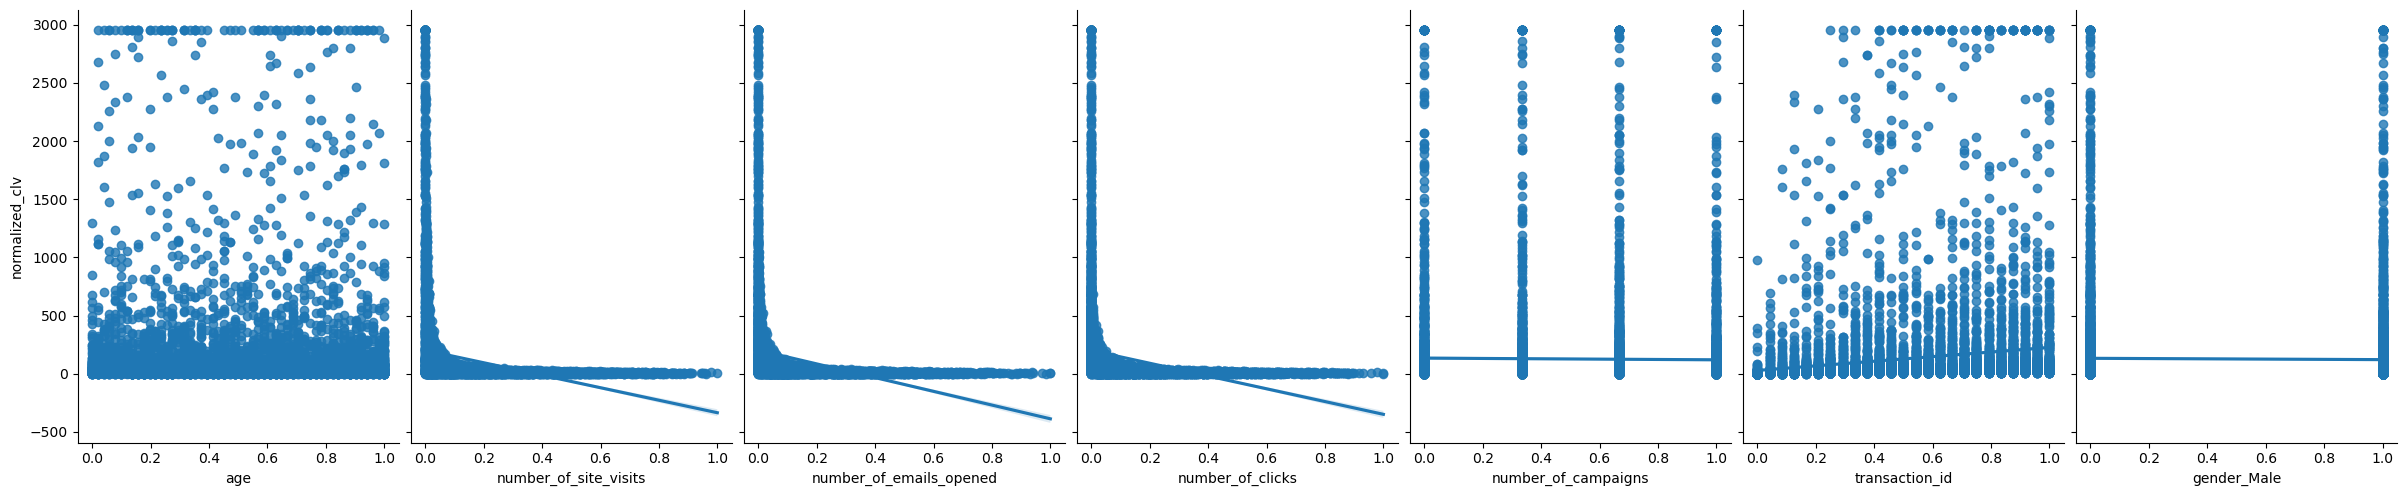

In [37]:

sns.pairplot(joint_dataa, x_vars=['age', 'number_of_site_visits', 'number_of_emails_opened',
            'number_of_clicks', 'number_of_campaigns', 'transaction_id', 'gender_Male'], y_vars='normalized_clv', height=5, aspect=0.7, kind='reg')
plt.show()

shows non linearity 

In [40]:
numerical_features = joint_dataa.select_dtypes(include=[np.number,'float64', 'int64', 'datetime'])

In [41]:
corr_matrix = numerical_features.corr()

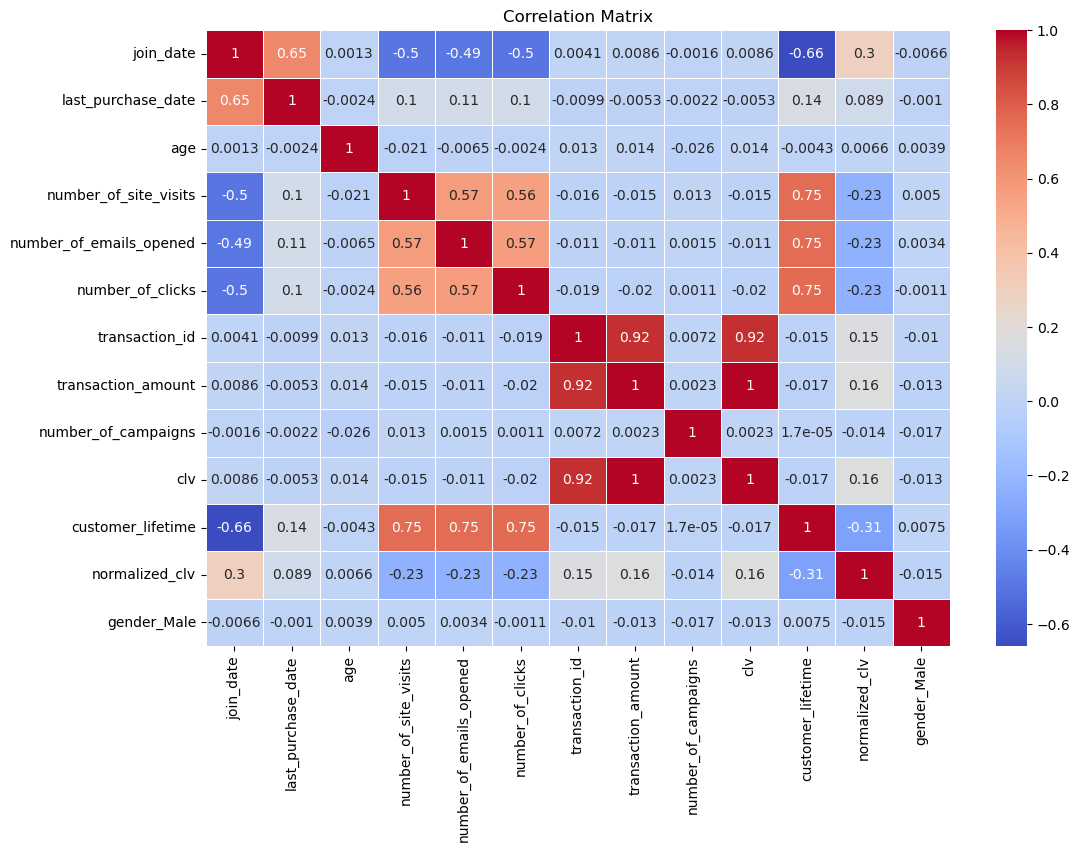

In [42]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

looks like somewhat high colinearity of data 
linear regression probably not best model 

In [63]:
print(X_train.columns)


Index(['age', 'number_of_site_visits', 'number_of_emails_opened',
       'number_of_clicks', 'number_of_campaigns', 'transaction_id',
       'gender_Male'],
      dtype='object')


In [65]:
print(y_train)

customer_id
786        5.434841
2631      14.217863
2993      29.852183
5342      19.049916
7345       4.460887
           ...     
6741    2958.195000
6092      22.244868
6331     916.347895
1024      76.960294
8544       8.036564
Name: normalized_clv, Length: 5965, dtype: float64


In [71]:
scores = cross_val_score(LinearRegression(), X_train[features], y_train, cv=5, scoring='neg_mean_squared_error')

In [72]:
mse_scores = -scores

In [73]:
print("Mean Squared Error scores for each fold:", mse_scores)
print("Average Mean Squared Error:", mse_scores.mean())

Mean Squared Error scores for each fold: [139973.32320137 136500.61134999 147332.2695618  142096.8389409
 157387.36597413]
Average Mean Squared Error: 144658.0818056379


The MSE values you obtained are quite high, which suggests that the model's predictions are far from the actual values.
This could be due to various reasons such as non-linearity in the data, presence of outliers, or multicollinearity among features.
Average MSE:

The average MSE of 144,658.08 provides an overall indication of the model's performance across all folds.
The variability among the fold MSEs (e.g., from 136,500 to 157,387) indicates some inconsistency in model performance, possibly due to different data distributions in each fold.


KNN

In [88]:
numerical_featuresss = joint_dataa.select_dtypes(include=[np.number, 'float64', 'int64'])

In [89]:
# Split the data into features and target variable
X = numerical_featuresss
y = 'normalized_clv'

In [90]:
print(X.dtypes)

age                        float64
number_of_site_visits      float64
number_of_emails_opened    float64
number_of_clicks           float64
transaction_id             float64
transaction_amount         float64
number_of_campaigns        float64
clv                        float64
customer_lifetime            int64
normalized_clv             float64
gender_Male                float64
dtype: object


In [91]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [94]:
knn_model = KNeighborsRegressor(n_neighbors=5) 

In [95]:
mse_scores_knn = cross_val_score(knn_model, X_scaled, y, scoring='neg_mean_squared_error', cv=5)
mse_scores_knn = -mse_scores_knn  # Convert to positive MSE scores

ValueError: Found input variables with inconsistent numbers of samples: [8522, 14]